# Assignment 5

### Importing Libraries

In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import *
import pandas as pd
import seaborn as sns  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Loading data on colab server
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip"

### Loading Data

In [3]:
# directory where data is loaded
data_dir = 'Assignment 5 Dataset'

# trans
# Adding data augmentation for better learning
# I calculated the mean and std using code that is present in last cell of the notebook  
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip(0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.219, 0.219, 0.219])])
# transforming testing data
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.219, 0.219, 0.219])])

# transforming validation data 
validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.219, 0.219, 0.219])])

# specifying train, test and validation data directories
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=validation_transforms)

# Loading Data
# i am using 8 threads and batches of 50 images for each type of data for better performance 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers = 8)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True, num_workers = 8)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=50, shuffle=True,num_workers = 8)

# Displaying Loaded data stats
print("Classes: ")
class_names = train_data.classes
print(class_names)
print(trainloader.dataset)
print(testloader.dataset)
print(validationloader.dataset)

Classes: 
['infected', 'normal']
Dataset ImageFolder
    Number of datapoints: 12000
    Root location: Assignment 5 Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               RandomHorizontalFlip(p=0.2)
               ToTensor()
               Normalize(mean=[0.517, 0.517, 0.517], std=[0.219, 0.219, 0.219])
           )
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: Assignment 5 Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.517, 0.517, 0.517], std=[0.219, 0.219, 0.219])
           )
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: Assignment 5 Dataset/validation
    Stand

### Displaying Images

Training images with augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


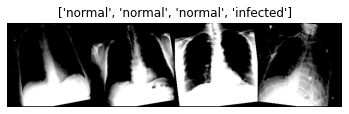

Testing images without augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


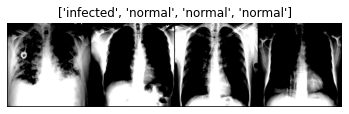

In [4]:
# Creating function to show images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# creating grid to display batch of images 
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
print('Training images with augmentation')
inputs, classes = next(iter(trainloader))
# displaying training images
show_databatch(inputs[:4], classes[:4])

# Get a batch of testing data
print('Testing images without augmentation')
inputs, classes = next(iter(testloader))
# displaying testing images
show_databatch(inputs[:4], classes[:4])

In [0]:
# Utilizing GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Training Function

In [0]:
# creating a function to train training data in differement experiments using different structures and models 
def train_model(model, epochs, training_data, validation_data, optimizer, criterion, filename):
    # Converting data to GPU processable form if available
    model.to(device)
    model.train()

    # creating arrays to store stats
    training_accuracy = []
    validation_accuracy = []
    training_loss = []
    validation_loss = []

    # Traing data
    for epoch in range(epochs):  # loop over the dataset multiple times
        # to show progress 
        pbar = tqdm(enumerate(training_data))
        
        # getting each batch for training 
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # feedforward
            outputs = model(inputs)
            # computing loss              
            loss = criterion(outputs, labels)
            # backprpagation   
            loss.backward() 
            # updating weights                    
            optimizer.step()                    

            # displaying progess
            pbar.set_description(
                'Training Epoch: {},({:.0f}%)'.format(
                    epoch+1, int((100. * i / len(training_data))+1)))
        
        # Displaying stats for current epoch
        # calculating stats on training data for current epoch
        print('\nFor training data')
        train_loss,train_accu,train_precision,train_recall,train_f1,train_confusion = scores(training_data,model)

        # calculating stats on validation data for current epoch
        print('\nFor validation data')
        valid_loss,valid_accu,valid_precision,valid_recall,valid_f1,valid_confusion = scores(validation_data,model)
        
        # storing stats in arrays to plot curves
        training_accuracy.append(train_accu)
        validation_accuracy.append(valid_accu)
        training_loss.append(train_loss)
        validation_loss.append(valid_loss)
        print("\nTraining Accuracy = ",train_accu, '\nTraining Loss = ',train_loss, "\nValidation Accuracy = ",valid_accu, '\nValidation Loss = ',valid_loss,"\n")  
    
    # displaing final epoch's stats on training data
    print('Final Stats:\n')
    train_stats = pd.DataFrame([train_loss,train_accu,train_precision,train_recall,train_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Training Scores']).T
    print(train_stats)
    print()
    
    # displaing final epoch's stats on validaiton data
    valid_stats = pd.DataFrame([valid_loss,valid_accu,valid_precision,valid_recall,valid_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Validation Scores']).T
    print(valid_stats)
    print()

    # displaying confusion matrix for training data
    sns.heatmap(train_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
    plt.title('Confusion Matrix for Training Data')
    plt.xlim(reversed(plt.xlim()))
    plt.show()
    print()

    # displaying confusion matrix for validation data
    sns.heatmap(valid_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
    plt.title('Confusion Matrix for Validation Data')
    plt.xlim(reversed(plt.xlim()))
    plt.show()
    print()

    # plotting cross entropy loss on training and validation data
    plt.title('Cross Entropy Loss')
    plt.plot(range(epochs),training_loss, label= 'Training Data')
    plt.plot(range(epochs),validation_loss,label='Validation Data')
    plt.ylim(0,1)
    plt.legend()
    plt.show()  
    print()
        
    # plotting accuracy for training and validation data
    plt.title('Accuracy')
    plt.plot(range(epochs),training_accuracy,label= 'Training Data')
    plt.plot(range(epochs),validation_accuracy,label= 'Validation Data')
    plt.ylim(70,100)
    plt.legend()
    plt.show()
    
    # saving the model
    torch.save(model.state_dict(), filename)
    

### Calculating Scores

In [0]:
def scores(dataset,model):
    correct = 0
    total = 0
    loss = 0
    predicted = []
    true_labels = []

    # getting prediction made by the model 
    with torch.no_grad():
        # to display progess
        pbar = tqdm(enumerate(dataset))
        # getting each batch 
        for i,data in pbar:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # Feedforward
            outputs = model(images)
            # calculating predictions by the model
            _, pred = torch.max(outputs.data, 1)
            # storing predictions in a list 
            predicted.extend(pred.tolist())
            # storing actutal labels in list
            true_labels.extend(labels.tolist())
            # calculating loss 
            loss += criterion(outputs, labels).item()

            # displaying progress
            pbar.set_description(
                'Calculating Accuracy and Loss: ({:.0f}%)'.format(
                    int((100. * i / len(dataset))+1)))
    
    # calculating loss on whole data
    total_loss = loss/len(dataset)
    # calculating accurate predictions of model on whole data
    accuracy = accuracy_score(true_labels,predicted)*100
    # calculating recall
    recall = recall_score(true_labels,predicted)*100
    # calculating precision
    precision = precision_score(true_labels,predicted)*100
    # calculating F1_Score
    f1 = f1_score(true_labels,predicted)*100
    # making confusion matrix
    confusion = pd.DataFrame(confusion_matrix(true_labels,predicted),['Infected','Normal'],['Infected','Normal'])

    return total_loss,accuracy,precision,recall,f1,confusion


## Task 1

### VGG-16

### Loading VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [22]:
# Adding new fully connected layers
features = []
# calculating no of units according to formula given in assignment
num_features = 87*10+100
# we have only two classes 'Normal' and 'Infected'
num_classes = 2
# Adding new layers to the model 
features.extend([nn.Linear(25088, num_features)])
# adding non linearity
features.extend([nn.ReLU(inplace=True)])
# adding dropout layer to avoid overftting
features.extend([nn.Dropout()])
# adding output layer
features.extend([nn.Linear(num_features, num_classes)])
vgg16.classifier = nn.Sequential(*features)
print('Now Model is as following:')
print(vgg16)

Now Model is as following:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stri

In [23]:
print('Following Parameters/Features are freezed:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias

Following Parameters/Features will be trained:
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


Training Epoch: 1,(100%): : 240it [02:44,  1.46it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:44,  1.46it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.43it/s]


Training Accuracy =  89.17500000000001 
Training Loss =  0.2776622225840886 
Validation Accuracy =  87.13333333333333 
Validation Loss =  0.3230557645360629 




Training Epoch: 2,(100%): : 240it [02:41,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.43it/s]


Training Accuracy =  90.325 
Training Loss =  0.24400019015495975 
Validation Accuracy =  87.73333333333333 
Validation Loss =  0.29746846705675123 




Training Epoch: 3,(100%): : 240it [02:40,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  89.325 
Training Loss =  0.2608362608278791 
Validation Accuracy =  86.66666666666667 
Validation Loss =  0.33649609188238777 




Training Epoch: 4,(100%): : 240it [02:40,  1.50it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.43it/s]


Training Accuracy =  90.78333333333333 
Training Loss =  0.23124709095185 
Validation Accuracy =  88.46666666666667 
Validation Loss =  0.30415187279383343 




Training Epoch: 5,(100%): : 240it [02:41,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  90.88333333333334 
Training Loss =  0.22964225116496284 
Validation Accuracy =  87.73333333333333 
Validation Loss =  0.3142293771107992 




Training Epoch: 6,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  91.55833333333334 
Training Loss =  0.21647520599265893 
Validation Accuracy =  88.13333333333333 
Validation Loss =  0.2934945945938428 




Training Epoch: 7,(100%): : 240it [02:39,  1.51it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.46it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  91.41666666666667 
Training Loss =  0.2144792900731166 
Validation Accuracy =  89.33333333333333 
Validation Loss =  0.30021719833215077 




Training Epoch: 8,(100%): : 240it [02:40,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.43it/s]


Training Accuracy =  91.96666666666667 
Training Loss =  0.20857422412373125 
Validation Accuracy =  88.86666666666667 
Validation Loss =  0.28995341112216316 




Training Epoch: 9,(100%): : 240it [02:40,  1.50it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.43it/s]


Training Accuracy =  91.75 
Training Loss =  0.2141769592805455 
Validation Accuracy =  88.66666666666667 
Validation Loss =  0.30534326334794365 




Training Epoch: 10,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:44,  1.46it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.41it/s]


Training Accuracy =  91.85833333333333 
Training Loss =  0.21439161663874984 
Validation Accuracy =  88.46666666666667 
Validation Loss =  0.2987174759308497 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.214392  91.858333  89.864159  97.161418  93.370428

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  0.298717  88.466667  87.953092  93.220339  90.510148



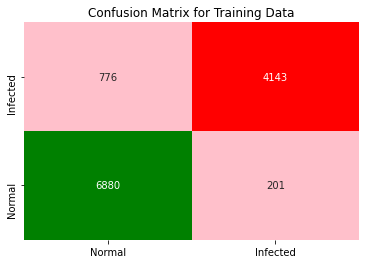

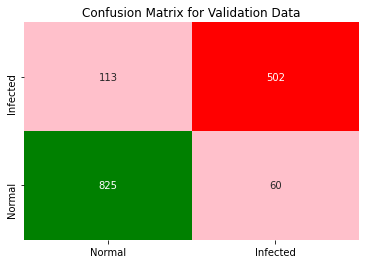

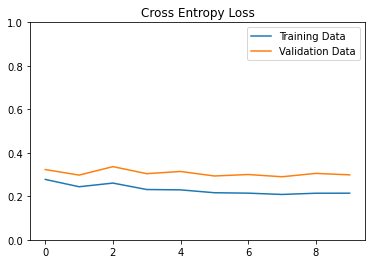

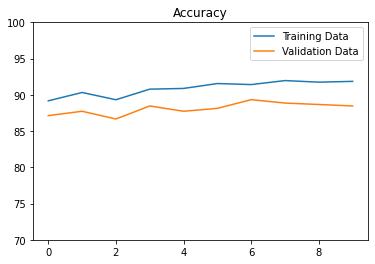

In [24]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
filename = 'vgg16_FC_Only.pth'
train_model(vgg16, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.38it/s]



                   Loss   Accuracy  Precision     Recall   F1_Score
Testing Score  0.175238  93.466667  91.817216  97.627119  94.633078


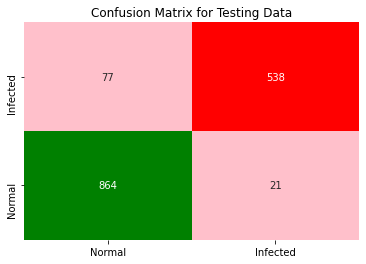

In [25]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,vgg16)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d) 
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


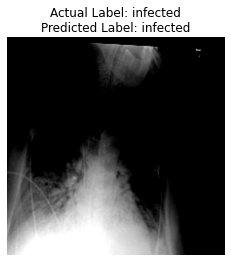

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


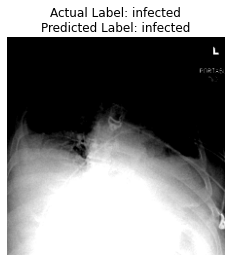

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


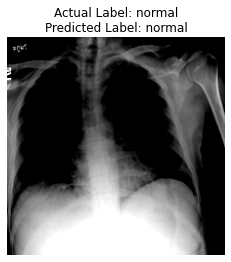

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


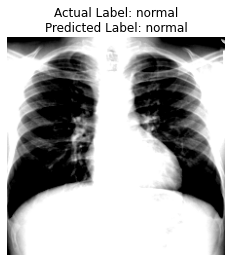

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


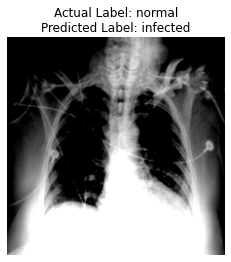

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


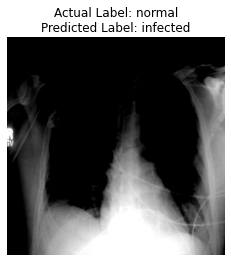

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


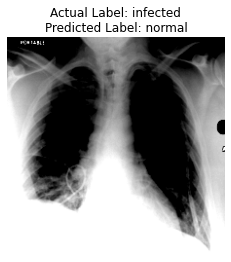

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


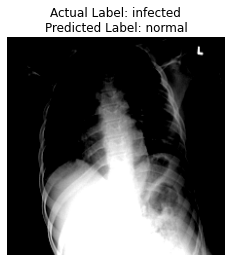

In [69]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = vgg16(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

### ResNet-18

### Loading Res-18

In [0]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Freeze training for all layers
for param in res18.parameters():
    param.requires_grad = False

In [0]:
features = []
num_features = 87*10+100
num_classes = 2
features.extend([nn.Linear(512, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
res18.fc = nn.Sequential(*features)
print('Now Model is as following:')
print(res18)

Now Model is as following:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

In [0]:
print('Following Parameters/Features are freezed:')
for name, param in res18.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in res18.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1

Training Epoch: 1,(100%): : 240it [04:00,  1.00s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:20,  1.09s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:31,  1.07s/it]
0it [00:00, ?it/s]


Training Accuracy =  85.96666666666667 
Training Loss =  0.34323829133063555 
Validation Accuracy =  83.39999999999999 
Validation Loss =  0.38779786626497903 



Training Epoch: 2,(100%): : 240it [04:00,  1.00s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:21,  1.09s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.08s/it]
0it [00:00, ?it/s]


Training Accuracy =  87.40833333333333 
Training Loss =  0.31404582789788643 
Validation Accuracy =  85.2 
Validation Loss =  0.36778670648733774 



Training Epoch: 3,(100%): : 240it [04:01,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:24,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.08s/it]
0it [00:00, ?it/s]


Training Accuracy =  87.78333333333333 
Training Loss =  0.3025319650148352 
Validation Accuracy =  84.53333333333333 
Validation Loss =  0.36556123594443 



Training Epoch: 4,(100%): : 240it [04:01,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:23,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.08s/it]
0it [00:00, ?it/s]


Training Accuracy =  88.21666666666667 
Training Loss =  0.28942226252208153 
Validation Accuracy =  85.53333333333333 
Validation Loss =  0.34857545644044874 



Training Epoch: 5,(100%): : 240it [04:00,  1.00s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:23,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.08s/it]
0it [00:00, ?it/s]


Training Accuracy =  88.10833333333333 
Training Loss =  0.2938326034384469 
Validation Accuracy =  84.73333333333333 
Validation Loss =  0.35725306818882624 



Training Epoch: 6,(100%): : 240it [04:01,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:22,  1.09s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.07s/it]
0it [00:00, ?it/s]


Training Accuracy =  88.78333333333333 
Training Loss =  0.2800653068659206 
Validation Accuracy =  84.73333333333333 
Validation Loss =  0.34732745637496315 



Training Epoch: 7,(100%): : 240it [03:57,  1.01it/s]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:21,  1.09s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:31,  1.07s/it]
0it [00:00, ?it/s]


Training Accuracy =  88.58333333333334 
Training Loss =  0.28282274982581534 
Validation Accuracy =  86.26666666666667 
Validation Loss =  0.34409111738204956 



Training Epoch: 8,(100%): : 240it [03:59,  1.00it/s]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:21,  1.09s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.09s/it]
0it [00:00, ?it/s]


Training Accuracy =  89.1 
Training Loss =  0.2757394893094897 
Validation Accuracy =  85.06666666666666 
Validation Loss =  0.3417104497551918 



Training Epoch: 9,(100%): : 240it [04:02,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:23,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.08s/it]
0it [00:00, ?it/s]


Training Accuracy =  88.81666666666666 
Training Loss =  0.27528726859018204 
Validation Accuracy =  85.33333333333334 
Validation Loss =  0.35004424353440605 



Training Epoch: 10,(100%): : 240it [04:01,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:21,  1.09s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.07s/it]


Training Accuracy =  88.875 
Training Loss =  0.2787815529232224 
Validation Accuracy =  85.46666666666667 
Validation Loss =  0.35247963642080626 

Final Stats:

                     Loss  Accuracy  Precision     Recall   F1_Score
Training Scores  0.278782    88.875  87.506527  94.661771  90.943627

                      Loss   Accuracy  Precision    Recall   F1_Score
Validation Scores  0.35248  85.466667  84.559585  92.20339  88.216216



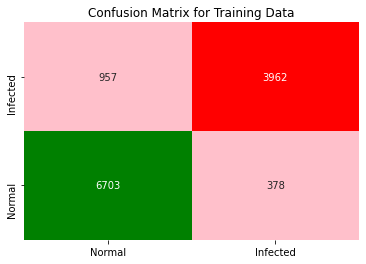

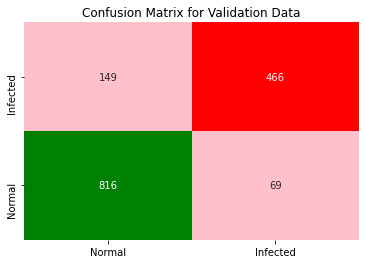

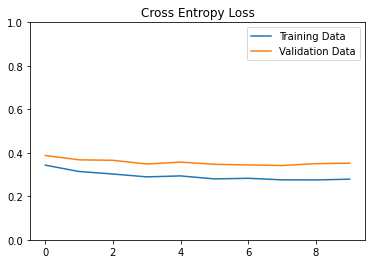

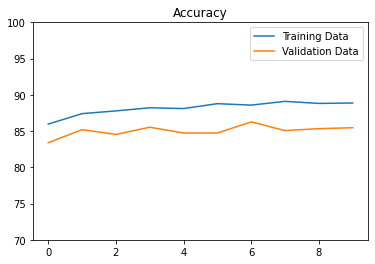

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)
filename = 'res18_FC_Only.pth'
train_model(res18, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.08s/it]


                   Loss   Accuracy  Precision     Recall   F1_Score
Testing Score  0.224981  91.533333  89.727463  96.723164  93.094073


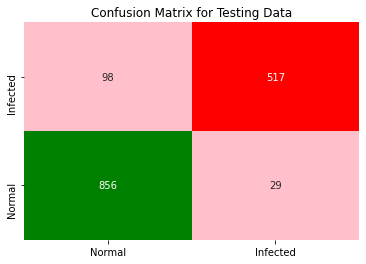

In [0]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,res18)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d)
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


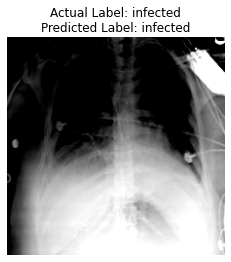

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


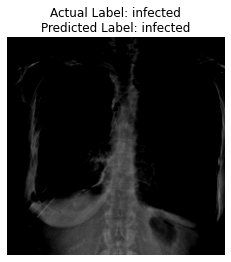

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


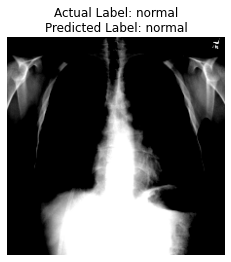

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


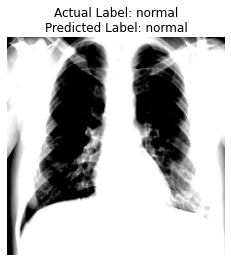

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


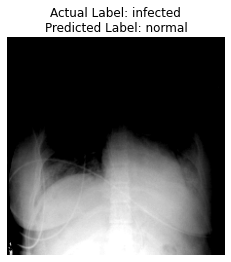

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


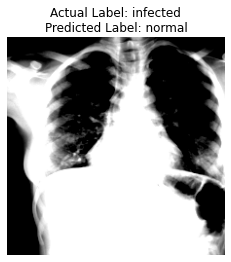

In [68]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = res18(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

## Task 2

### Experiment 1 (Unfreezing Last Layer before Fully Connected)

### VGG-16

In [0]:
vgg16 = models.vgg16(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 2
features.extend([nn.Linear(25088, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
vgg16.classifier = nn.Sequential(*features)

In [0]:
i = 0
for param in vgg16.features.parameters():
    i=i+1
    if i>=25:
        param.requires_grad = True
    else:
        param.requires_grad = False


In [28]:
print('Following Parameters/Features are freezed:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias

Following Parameters/Features will be trained:
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


Training Epoch: 1,(100%): : 240it [02:44,  1.46it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]



Training Accuracy =  90.13333333333333 
Training Loss =  0.24768463059638937 
Validation Accuracy =  87.8 
Validation Loss =  0.30333491464455925 



Training Epoch: 2,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]



Training Accuracy =  91.10833333333333 
Training Loss =  0.23124650605022906 
Validation Accuracy =  87.73333333333333 
Validation Loss =  0.2876136933763822 



Training Epoch: 3,(100%): : 240it [02:41,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.43it/s]



Training Accuracy =  90.24166666666666 
Training Loss =  0.24312284588813782 
Validation Accuracy =  89.13333333333333 
Validation Loss =  0.30345168883601825 



Training Epoch: 4,(100%): : 240it [02:40,  1.50it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]



Training Accuracy =  92.2 
Training Loss =  0.21181511708224812 
Validation Accuracy =  87.86666666666667 
Validation Loss =  0.2981974405546983 



Training Epoch: 5,(100%): : 240it [02:42,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  92.34166666666667 
Training Loss =  0.19435936609903973 
Validation Accuracy =  89.8 
Validation Loss =  0.2775562008221944 




Training Epoch: 6,(100%): : 240it [02:40,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]



Training Accuracy =  92.4 
Training Loss =  0.19754940004398425 
Validation Accuracy =  89.8 
Validation Loss =  0.282437231640021 



Training Epoch: 7,(100%): : 240it [02:40,  1.50it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]



Training Accuracy =  92.94166666666666 
Training Loss =  0.1835653900168836 
Validation Accuracy =  89.06666666666668 
Validation Loss =  0.26993613118926685 



Training Epoch: 8,(100%): : 240it [02:41,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  93.15 
Training Loss =  0.18033522403178115 
Validation Accuracy =  89.66666666666666 
Validation Loss =  0.27146985655029615 




Training Epoch: 9,(100%): : 240it [02:39,  1.50it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:41,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.44it/s]


Training Accuracy =  93.5 
Training Loss =  0.1720497825803856 
Validation Accuracy =  89.73333333333333 
Validation Loss =  0.2680414289236069 




Training Epoch: 10,(100%): : 240it [02:39,  1.51it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:44,  1.46it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.41it/s]


Training Accuracy =  93.20833333333334 
Training Loss =  0.17417139671742915 
Validation Accuracy =  89.4 
Validation Loss =  0.2691802846888701 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.174171  93.208333  92.718844  96.031634  94.346167

                      Loss  Accuracy  Precision     Recall   F1_Score
Validation Scores  0.26918      89.4  89.977974  92.316384  91.132181



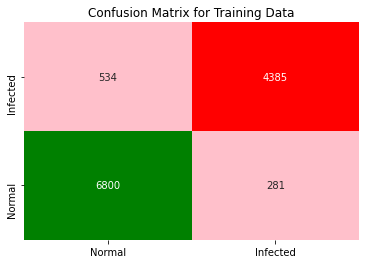

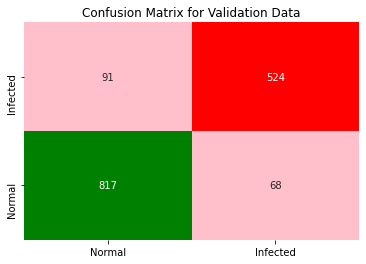

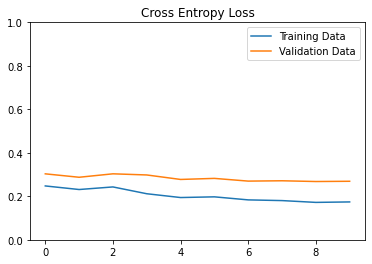

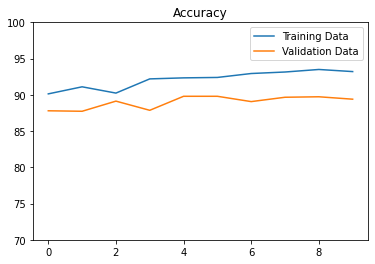

In [29]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
filename = 'vgg16_task2_exp1.pth'
train_model(vgg16, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.38it/s]


                   Loss   Accuracy  Precision     Recall   F1_Score
Testing Score  0.135289  95.533333  94.846491  97.740113  96.271564


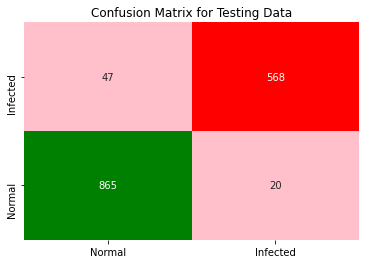

In [30]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,vgg16)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d)
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


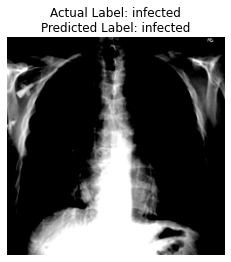

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


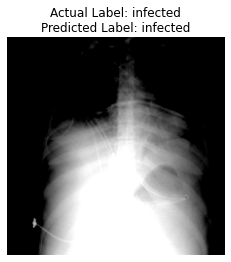

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


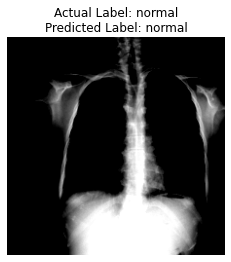

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


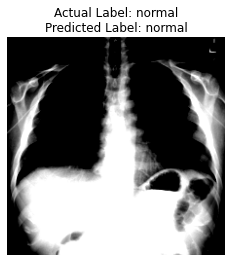

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


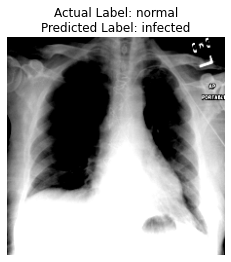

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


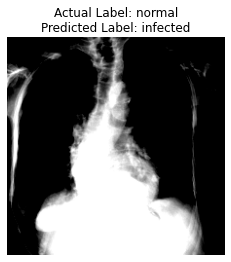

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


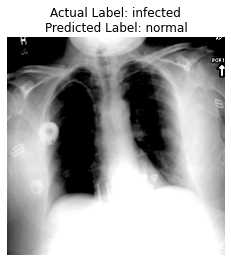

In [67]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = vgg16(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

### ResNet-18

In [0]:
res18 = models.resnet18(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 2
features.extend([nn.Linear(512, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
res18.fc = nn.Sequential(*features)

In [0]:
# Freeze training for all layers
i = 0
for param in res18.parameters():
    i=i+1
    if i >= 58:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [0]:
print('Following Parameters/Features are freezed:')
for name, param in res18.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in res18.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1

Training Epoch: 1,(100%): : 240it [04:01,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:27,  1.12s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:33,  1.12s/it]
0it [00:00, ?it/s]


Training Accuracy =  86.93333333333332 
Training Loss =  0.32171535460899275 
Validation Accuracy =  84.66666666666667 
Validation Loss =  0.3757552832365036 



Training Epoch: 2,(100%): : 240it [04:11,  1.05s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:31,  1.13s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:33,  1.11s/it]
0it [00:00, ?it/s]


Training Accuracy =  88.725 
Training Loss =  0.2889646035308639 
Validation Accuracy =  84.46666666666667 
Validation Loss =  0.34830254763364793 



Training Epoch: 3,(100%): : 240it [04:05,  1.02s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:23,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.08s/it]
0it [00:00, ?it/s]


Training Accuracy =  89.10833333333333 
Training Loss =  0.2711601153947413 
Validation Accuracy =  87.0 
Validation Loss =  0.32927729239066444 



Training Epoch: 4,(100%): : 240it [04:02,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:24,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:33,  1.11s/it]
0it [00:00, ?it/s]


Training Accuracy =  89.67500000000001 
Training Loss =  0.25633911540110904 
Validation Accuracy =  86.0 
Validation Loss =  0.34305641502141954 



Training Epoch: 5,(100%): : 240it [04:12,  1.05s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:24,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.07s/it]
0it [00:00, ?it/s]


Training Accuracy =  90.16666666666666 
Training Loss =  0.2505316275792817 
Validation Accuracy =  86.26666666666667 
Validation Loss =  0.33688703626394273 



Training Epoch: 6,(100%): : 240it [04:02,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:23,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.09s/it]
0it [00:00, ?it/s]


Training Accuracy =  90.54166666666667 
Training Loss =  0.241662007663399 
Validation Accuracy =  86.8 
Validation Loss =  0.32556724498669304 



Training Epoch: 7,(100%): : 240it [04:05,  1.02s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:25,  1.11s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.09s/it]
0it [00:00, ?it/s]


Training Accuracy =  90.85833333333333 
Training Loss =  0.23497356267956396 
Validation Accuracy =  87.0 
Validation Loss =  0.3274026532967885 



Training Epoch: 8,(100%): : 240it [04:03,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:24,  1.10s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:33,  1.11s/it]
0it [00:00, ?it/s]


Training Accuracy =  90.99166666666667 
Training Loss =  0.2277814078765611 
Validation Accuracy =  86.2 
Validation Loss =  0.3350228160619736 



Training Epoch: 9,(100%): : 240it [04:03,  1.01s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:25,  1.11s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.09s/it]
0it [00:00, ?it/s]


Training Accuracy =  91.025 
Training Loss =  0.22860415304700535 
Validation Accuracy =  86.13333333333333 
Validation Loss =  0.33152546087900797 



Training Epoch: 10,(100%): : 240it [04:03,  1.02s/it]
0it [00:00, ?it/s]


For training data


Calculating Accuracy and Loss: (100%): : 240it [04:26,  1.11s/it]
0it [00:00, ?it/s]


For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:33,  1.11s/it]


Training Accuracy =  91.35833333333333 
Training Loss =  0.21799687302360932 
Validation Accuracy =  86.8 
Validation Loss =  0.3224303995569547 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.217997  91.358333  91.705769  93.842678  92.761918

                      Loss  Accuracy  Precision     Recall   F1_Score
Validation Scores  0.32243      86.8  87.955801  89.943503  88.938547



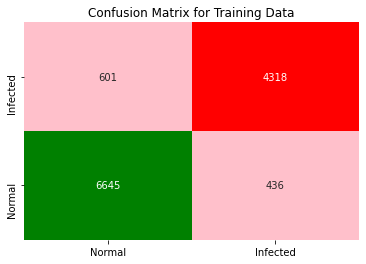

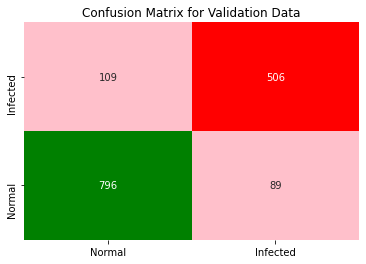

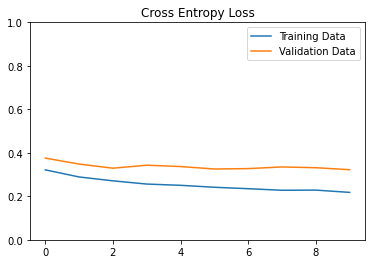

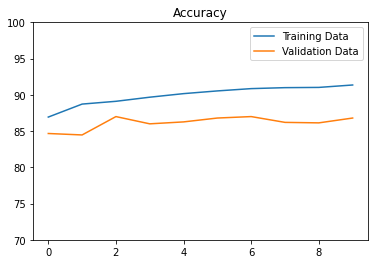

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)
filename = 'res18_task2_exp1.pth'
train_model(res18, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:32,  1.09s/it]


                   Loss   Accuracy  Precision     Recall   F1_Score
Testing Score  0.187028  93.066667  92.771084  95.706215  94.215795


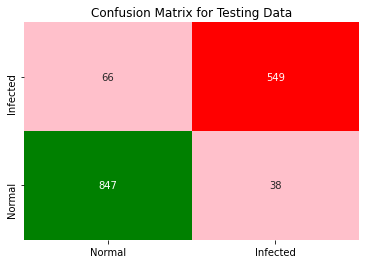

In [0]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,res18)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d)
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


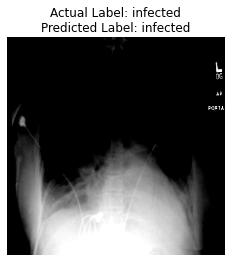

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


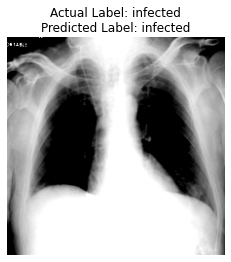

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


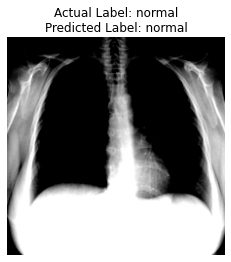

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


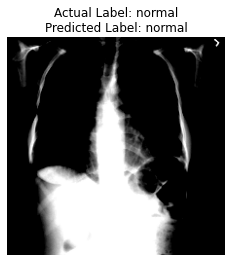

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


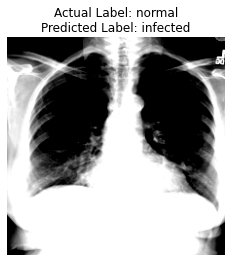

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


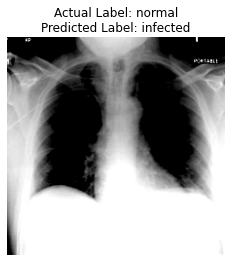

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


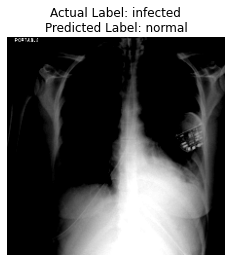

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


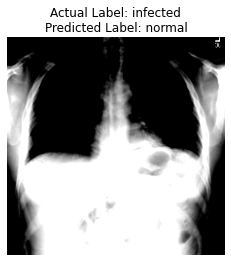

In [66]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = res18(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

### Experiment 2 (Unfreezing few Layers before Fully Connected)

### VGG-16

In [0]:
vgg16 = models.vgg16(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 2
features.extend([nn.Linear(25088, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
vgg16.classifier = nn.Sequential(*features)

In [0]:
i = 0
for param in vgg16.features.parameters():
    i=i+1
    if i > 16:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [33]:
print('Following Parameters/Features are freezed:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias

Following Parameters/Features will be trained:
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


Training Epoch: 1,(100%): : 240it [02:44,  1.45it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:44,  1.46it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.41it/s]


Training Accuracy =  91.71666666666667 
Training Loss =  0.21307423091493546 
Validation Accuracy =  89.33333333333333 
Validation Loss =  0.27864502370357513 




Training Epoch: 2,(100%): : 240it [02:43,  1.47it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:41,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.41it/s]


Training Accuracy =  93.7 
Training Loss =  0.16981057124212384 
Validation Accuracy =  90.66666666666666 
Validation Loss =  0.22845326562722523 




Training Epoch: 3,(100%): : 240it [02:44,  1.46it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.46it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  94.03333333333333 
Training Loss =  0.16053613750264048 
Validation Accuracy =  91.0 
Validation Loss =  0.22767770811915397 




Training Epoch: 4,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  94.24166666666667 
Training Loss =  0.1550274340280642 
Validation Accuracy =  90.66666666666666 
Validation Loss =  0.24335096925497054 




Training Epoch: 5,(100%): : 240it [02:43,  1.47it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:45,  1.45it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  94.69166666666666 
Training Loss =  0.14050097898580133 
Validation Accuracy =  91.53333333333333 
Validation Loss =  0.22782613063851992 




Training Epoch: 6,(100%): : 240it [02:44,  1.46it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]


Training Accuracy =  93.175 
Training Loss =  0.18325560789865752 
Validation Accuracy =  90.60000000000001 
Validation Loss =  0.25794659766058126 




Training Epoch: 7,(100%): : 240it [02:45,  1.45it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.41it/s]


Training Accuracy =  95.39999999999999 
Training Loss =  0.1253616420319304 
Validation Accuracy =  91.33333333333333 
Validation Loss =  0.2264978937804699 




Training Epoch: 8,(100%): : 240it [02:44,  1.46it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:45,  1.45it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.41it/s]


Training Accuracy =  95.13333333333334 
Training Loss =  0.13028784698884313 
Validation Accuracy =  90.93333333333334 
Validation Loss =  0.25104459896683695 




Training Epoch: 9,(100%): : 240it [02:44,  1.46it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:45,  1.45it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.39it/s]


Training Accuracy =  95.58333333333333 
Training Loss =  0.11756659084931016 
Validation Accuracy =  91.4 
Validation Loss =  0.22215180409451327 




Training Epoch: 10,(100%): : 240it [02:45,  1.45it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:46,  1.44it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.38it/s]


Training Accuracy =  96.11666666666666 
Training Loss =  0.10647555739463617 
Validation Accuracy =  91.4 
Validation Loss =  0.23513218363126118 

Final Stats:

                     Loss   Accuracy  Precision    Recall   F1_Score
Training Scores  0.106476  96.116667  96.110414  97.35913  96.730742

                       Loss  Accuracy  Precision    Recall   F1_Score
Validation Scores  0.235132      91.4   92.47191  92.99435  92.732394



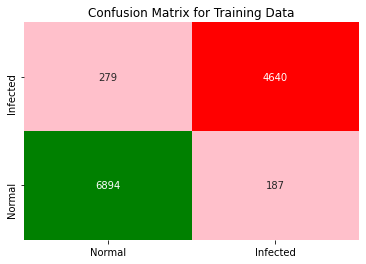

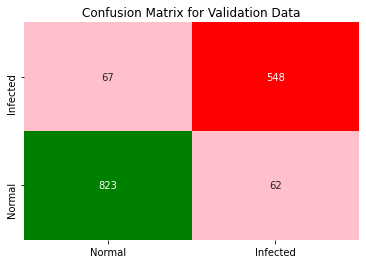

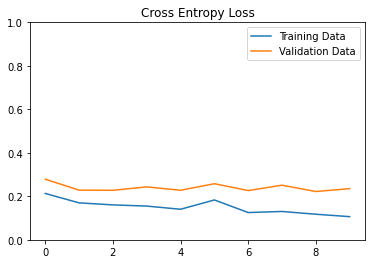

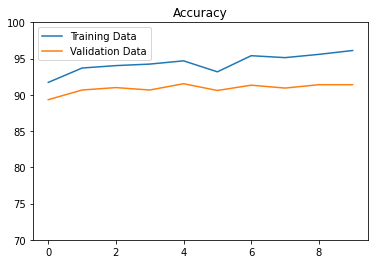

In [34]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
filename = 'vgg16_task2_exp2.pth'
train_model(vgg16, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:22,  1.34it/s]


                   Loss   Accuracy  Precision     Recall   F1_Score
Testing Score  0.102827  96.666667  96.544036  97.853107  97.194164


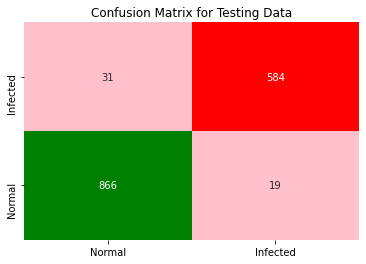

In [35]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,vgg16)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d)
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


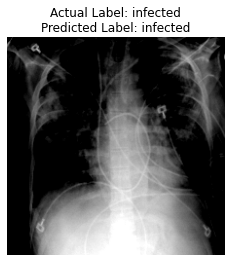

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


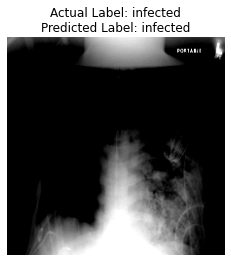

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


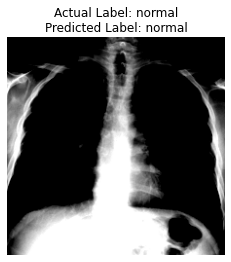

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


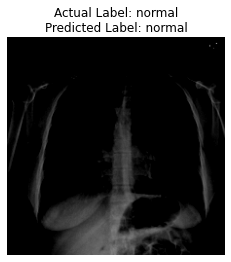

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


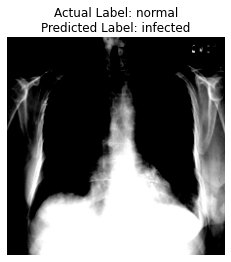

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


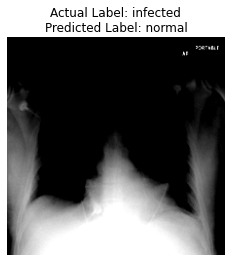

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


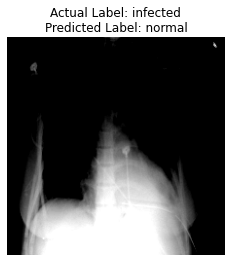

In [65]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = vgg16(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

### ResNet-18

In [0]:
res18 = models.resnet18(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 2
features.extend([nn.Linear(512, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
res18.fc = nn.Sequential(*features)

In [0]:
# Freeze training for all layers
i = 0
for param in res18.parameters():
    i=i+1
    if i > 45:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [0]:
print('Following Parameters/Features are freezed:')
for name, param in res18.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in res18.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias

Following Parameters/Features wil

Training Epoch: 1,(100%): : 240it [02:54,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:47,  1.43it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.48it/s]


Training Accuracy =  85.975 
Training Loss =  0.3424680451552073 
Validation Accuracy =  85.86666666666667 
Validation Loss =  0.3428072094917297 




Training Epoch: 2,(100%): : 240it [02:45,  1.45it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:44,  1.46it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.56it/s]


Training Accuracy =  87.00833333333333 
Training Loss =  0.3173805629834533 
Validation Accuracy =  87.53333333333333 
Validation Loss =  0.31921733021736143 




Training Epoch: 3,(100%): : 240it [02:43,  1.47it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.57it/s]


Training Accuracy =  87.75 
Training Loss =  0.3072060138608019 
Validation Accuracy =  86.93333333333332 
Validation Loss =  0.29957266549269357 




Training Epoch: 4,(100%): : 240it [02:42,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:18,  1.58it/s]


Training Accuracy =  88.47500000000001 
Training Loss =  0.2869888082767526 
Validation Accuracy =  87.4 
Validation Loss =  0.2922252138455709 




Training Epoch: 5,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:41,  1.49it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.58it/s]


Training Accuracy =  88.74166666666666 
Training Loss =  0.2791572595946491 
Validation Accuracy =  88.06666666666668 
Validation Loss =  0.3008953963716825 




Training Epoch: 6,(100%): : 240it [02:40,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:40,  1.50it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:18,  1.59it/s]


Training Accuracy =  88.81666666666666 
Training Loss =  0.2731640227449437 
Validation Accuracy =  88.6 
Validation Loss =  0.2853366355101267 




Training Epoch: 7,(100%): : 240it [02:42,  1.47it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.47it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.56it/s]


Training Accuracy =  89.56666666666668 
Training Loss =  0.2572236118217309 
Validation Accuracy =  88.53333333333333 
Validation Loss =  0.2801048432787259 




Training Epoch: 8,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:41,  1.48it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.57it/s]


Training Accuracy =  89.5 
Training Loss =  0.25978006593262154 
Validation Accuracy =  88.6 
Validation Loss =  0.2734606015185515 




Training Epoch: 9,(100%): : 240it [02:40,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:41,  1.48it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.58it/s]


Training Accuracy =  89.69166666666666 
Training Loss =  0.25456933928653597 
Validation Accuracy =  88.2 
Validation Loss =  0.2775456361472607 




Training Epoch: 10,(100%): : 240it [02:40,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:41,  1.49it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 30it [00:18,  1.58it/s]



Training Accuracy =  89.775 
Training Loss =  0.2523332375412186 
Validation Accuracy =  88.73333333333333 
Validation Loss =  0.27559815620382627 

Final Stats:

                     Loss  Accuracy  Precision     Recall   F1_Score
Training Scores  0.252333    89.775  90.383554  92.515181  91.436946

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  0.275598  88.733333   91.24424  89.491525  90.359384



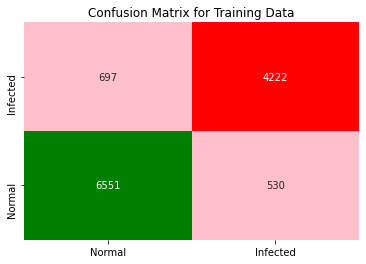

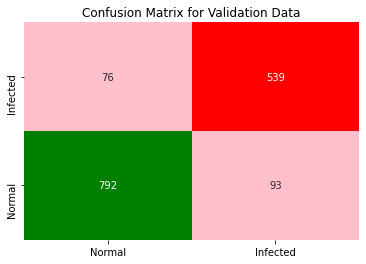

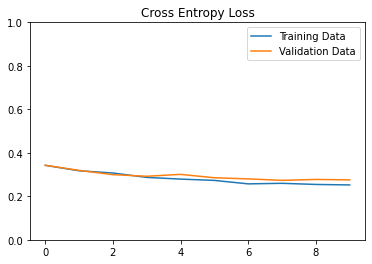

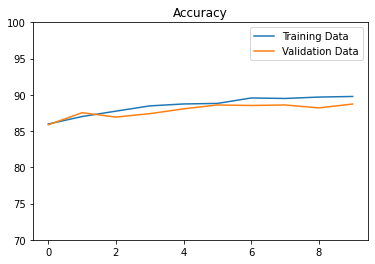

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)
filename = 'res18_task2_exp2.pth'
train_model(res18, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:23,  1.26it/s]


                   Loss  Accuracy  Rrecision     Recall   F1_Score
Testing Score  0.173543      94.4  96.193772  94.237288  95.205479


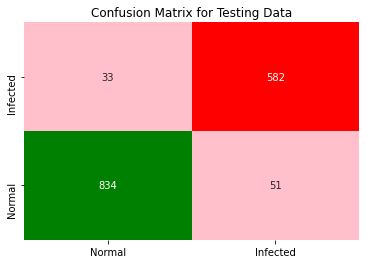

In [0]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,res18)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d)
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


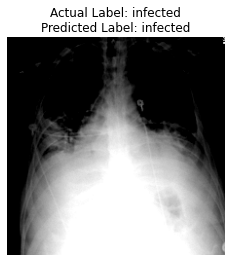

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


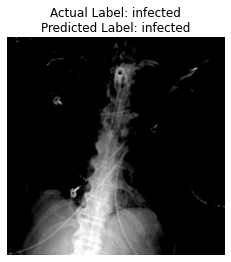

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


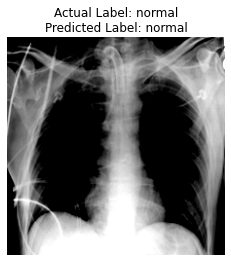

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


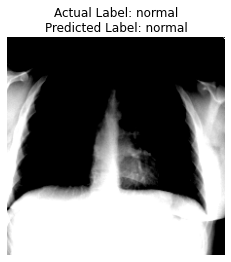

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


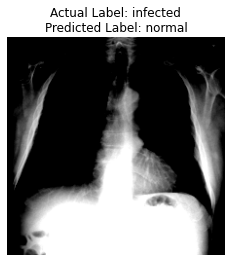

In [64]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = res18(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

### Experiment 3 (Unfreezing All Layer)

### VGG-16

In [0]:
vgg16 = models.vgg16(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 2
features.extend([nn.Linear(25088, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
vgg16.classifier = nn.Sequential(*features)

In [0]:
for param in vgg16.features.parameters():
    param.requires_grad = True

In [10]:
print('Following Parameters/Features are freezed:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:

Following Parameters/Features will be trained:
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


Training Epoch: 1,(100%): : 240it [03:26,  1.16it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:54,  1.37it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:22,  1.31it/s]


Training Accuracy =  92.23333333333333 
Training Loss =  0.20054997475817798 
Validation Accuracy =  89.33333333333333 
Validation Loss =  0.2623413388927778 




Training Epoch: 2,(100%): : 240it [03:33,  1.13it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:50,  1.40it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:22,  1.36it/s]


Training Accuracy =  93.975 
Training Loss =  0.16221725163049996 
Validation Accuracy =  90.66666666666666 
Validation Loss =  0.23117465923229855 




Training Epoch: 3,(100%): : 240it [03:32,  1.13it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:52,  1.39it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:22,  1.35it/s]


Training Accuracy =  93.425 
Training Loss =  0.1673113945716371 
Validation Accuracy =  90.26666666666667 
Validation Loss =  0.24737904344995817 




Training Epoch: 4,(100%): : 240it [03:33,  1.13it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [03:05,  1.29it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:22,  1.33it/s]


Training Accuracy =  94.41666666666667 
Training Loss =  0.1467846090051656 
Validation Accuracy =  91.13333333333333 
Validation Loss =  0.224746976668636 




Training Epoch: 5,(100%): : 240it [03:33,  1.12it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:57,  1.35it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.38it/s]



Training Accuracy =  93.68333333333332 
Training Loss =  0.16965877485927194 
Validation Accuracy =  90.46666666666667 
Validation Loss =  0.2788244637350241 



Training Epoch: 6,(100%): : 240it [03:32,  1.13it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:46,  1.44it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.37it/s]



Training Accuracy =  95.39999999999999 
Training Loss =  0.12375256442464888 
Validation Accuracy =  91.60000000000001 
Validation Loss =  0.22958539115885893 



Training Epoch: 7,(100%): : 240it [03:33,  1.13it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:48,  1.43it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.38it/s]



Training Accuracy =  95.73333333333333 
Training Loss =  0.11971520337586601 
Validation Accuracy =  91.4 
Validation Loss =  0.21427921801805497 



Training Epoch: 8,(100%): : 240it [03:33,  1.13it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:50,  1.41it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:22,  1.36it/s]



Training Accuracy =  95.89166666666667 
Training Loss =  0.11205429756858697 
Validation Accuracy =  92.46666666666667 
Validation Loss =  0.20589642164607844 



Training Epoch: 9,(100%): : 240it [03:32,  1.13it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:50,  1.41it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.37it/s]


Training Accuracy =  95.39166666666667 
Training Loss =  0.12701097156386823 
Validation Accuracy =  90.26666666666667 
Validation Loss =  0.2527111016213894 




Training Epoch: 10,(100%): : 240it [03:33,  1.12it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:52,  1.40it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.39it/s]



Training Accuracy =  96.35833333333333 
Training Loss =  0.09664414216919491 
Validation Accuracy =  92.06666666666666 
Validation Loss =  0.23423614079753557 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.096644  96.358333  96.565742  97.288519  96.925783

                       Loss   Accuracy  Precision     Recall  F1_Score
Validation Scores  0.234236  92.066667   92.93722  93.672316  93.30332



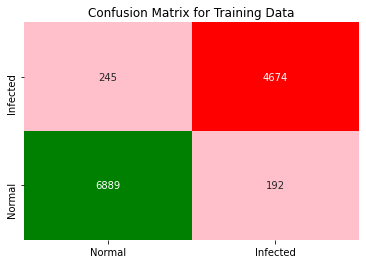

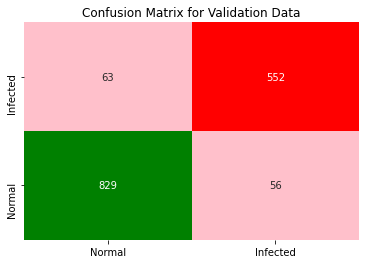

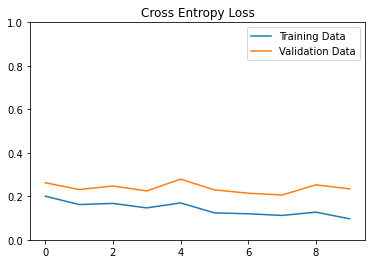

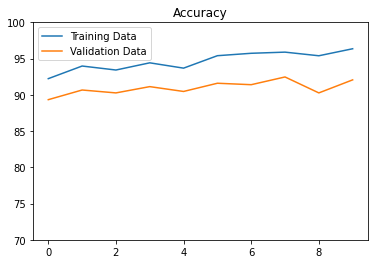

In [11]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
filename = '‘vgg16_entire.pth'
train_model(vgg16, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:21,  1.42it/s]



                   Loss   Accuracy  Precision     Recall   F1_Score
Testing Score  0.096507  97.533333  97.111111  98.757062  97.927171


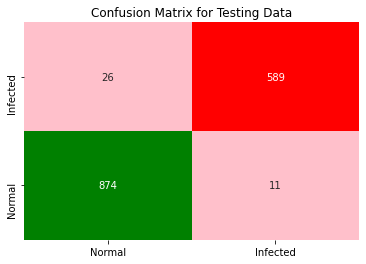

In [13]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,vgg16)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d)
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


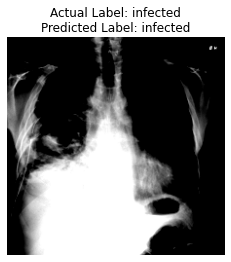

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


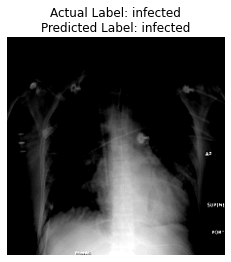

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


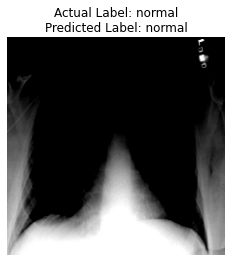

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


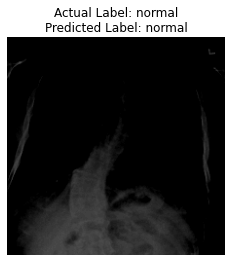

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


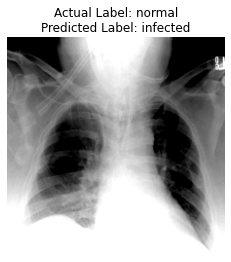

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


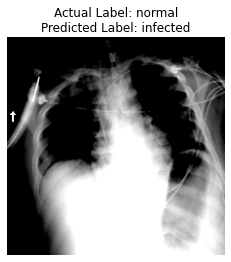

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


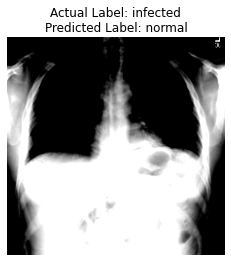

In [63]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = vgg16(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

### ResNet-18

In [14]:
res18 = models.resnet18(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 2
features.extend([nn.Linear(512, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
res18.fc = nn.Sequential(*features)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Freeze training for all layers
for param in res18.parameters():
    param.requires_grad = True

In [16]:
print('Following Parameters/Features are freezed:')
for name, param in res18.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in res18.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:

Following Parameters/Features will be trained:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
laye

Training Epoch: 1,(100%): : 240it [02:41,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:39,  1.51it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.52it/s]



Training Accuracy =  91.14999999999999 
Training Loss =  0.22542912935217221 
Validation Accuracy =  87.86666666666667 
Validation Loss =  0.2868258391817411 



Training Epoch: 2,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:39,  1.51it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.55it/s]


Training Accuracy =  92.675 
Training Loss =  0.19309889264404773 
Validation Accuracy =  88.73333333333333 
Validation Loss =  0.2717001919945081 




Training Epoch: 3,(100%): : 240it [02:48,  1.43it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:44,  1.46it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.50it/s]


Training Accuracy =  93.50833333333334 
Training Loss =  0.17774571101181208 
Validation Accuracy =  89.8 
Validation Loss =  0.256794323772192 




Training Epoch: 4,(100%): : 240it [02:46,  1.45it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:41,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.51it/s]



Training Accuracy =  93.825 
Training Loss =  0.16159091365213196 
Validation Accuracy =  89.86666666666666 
Validation Loss =  0.2470788076519966 



Training Epoch: 5,(100%): : 240it [02:45,  1.45it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:43,  1.47it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.48it/s]



Training Accuracy =  94.25 
Training Loss =  0.15219250676066925 
Validation Accuracy =  90.46666666666667 
Validation Loss =  0.2422050043940544 



Training Epoch: 6,(100%): : 240it [02:47,  1.43it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:42,  1.48it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:20,  1.48it/s]


Training Accuracy =  94.53333333333333 
Training Loss =  0.1489546412291626 
Validation Accuracy =  91.06666666666666 
Validation Loss =  0.23727205470204354 




Training Epoch: 7,(100%): : 240it [02:41,  1.48it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:37,  1.52it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.52it/s]


Training Accuracy =  95.08333333333333 
Training Loss =  0.13662196388468145 
Validation Accuracy =  90.86666666666666 
Validation Loss =  0.25077326645453774 




Training Epoch: 8,(100%): : 240it [02:39,  1.50it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:36,  1.54it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.56it/s]



Training Accuracy =  95.125 
Training Loss =  0.1294825979353239 
Validation Accuracy =  91.0 
Validation Loss =  0.23955236772696178 



Training Epoch: 9,(100%): : 240it [02:39,  1.51it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:37,  1.53it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.56it/s]



Training Accuracy =  95.33333333333334 
Training Loss =  0.12229060297831892 
Validation Accuracy =  89.53333333333333 
Validation Loss =  0.2502077062924703 



Training Epoch: 10,(100%): : 240it [02:40,  1.49it/s]


For training data



Calculating Accuracy and Loss: (100%): : 240it [02:36,  1.53it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.56it/s]



Training Accuracy =  95.675 
Training Loss =  0.11733657567140957 
Validation Accuracy =  91.06666666666666 
Validation Loss =  0.23896865074833235 

Final Stats:

                     Loss  Accuracy  Precision     Recall   F1_Score
Training Scores  0.117337    95.675  95.443213  97.316763  96.370883

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  0.238969  91.066667  91.309131  93.785311  92.530658



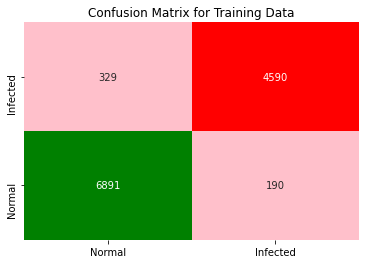

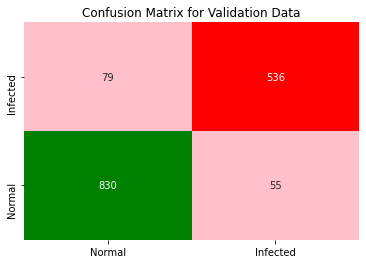

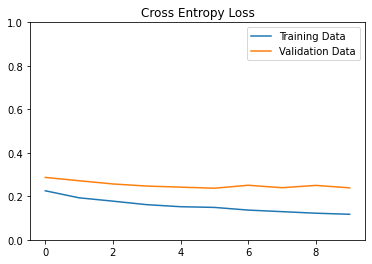

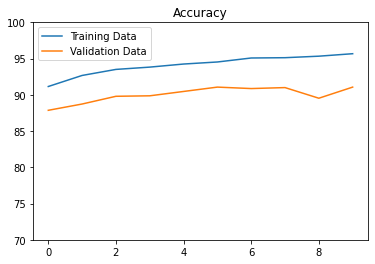

In [17]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)
filename = '‘res18_entire.pth'
train_model(res18, Epochs,trainloader, validationloader, optimizer, criterion, filename)

Calculating Accuracy and Loss: (97%): : 30it [00:19,  1.54it/s]



                   Loss  Accuracy  Precision    Recall   F1_Score
Testing Score  0.118327      96.6  96.128319  98.19209  97.149245


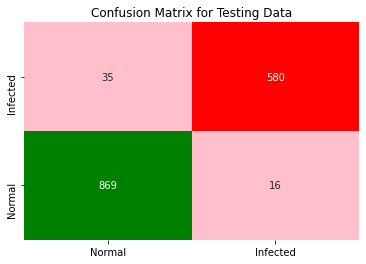

In [18]:
test_loss,test_accu,test_precision,test_recall,test_f1,test_confusion = scores(testloader,res18)
d = pd.DataFrame([test_loss,test_accu,test_precision,test_recall,test_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Testing Score']).T
print()
print(d)
sns.heatmap(test_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
plt.title('Confusion Matrix for Testing Data')
plt.xlim(reversed(plt.xlim()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


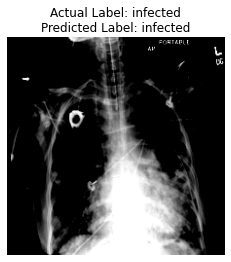

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


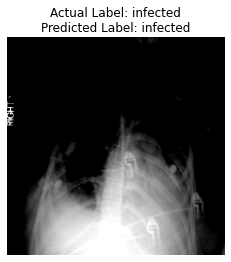

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


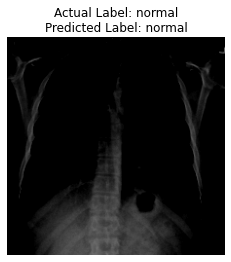

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


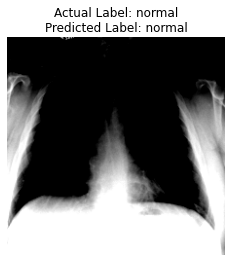

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


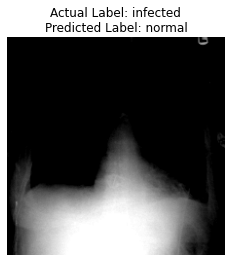

In [62]:
# i used validation data as it is easy to get all types of images from it
# training and testing accury is high so to get desired images are hard 
dataiter = iter(validationloader)
images, labels = dataiter.next()
imgs = images.to(device)
outputs = res18(imgs)                              
_, predicted = torch.max(outputs, 1)

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 0 and labels[i] == 1 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

k = 1
for i in range(50):
    if predicted[i] == 1 and labels[i] == 0 and k<=2:
        imshow(images[i],'Actual Label: '+str(class_names[labels[i]]+'\nPredicted Label: '+str(class_names[predicted[i]])))
        k+=1

In [0]:
# To calculate Mean and Standard Deviation to normalize images 
# mean = []
# std = []
# for images, labels in trainloader:
#     numpy_images = images.numpy()
#     mean.append(np.mean(numpy_images, axis=(0, 2, 3)))
#     std.append(np.std(numpy_images, axis=(0, 2, 3)))    
# print(np.mean(np.array(mean),axis=0))
# print(np.mean(np.array(std),axis=0))